## Computer Vision

# Problem-based learning: Fingerprint verification

## Outline

- **Set-up**
- **Part I: Fingerprint segmentation**
  - Class `FpSegmentator`

- **Part II: Fingerprint enhancement**
  - Class `OfDetector`
  - Class `GaborFilter`
  - Class `GaborFilterbank`
  - Class `FpEnhancer`

- **Part III: Minutia extraction**
  - Class `Binarizer`
  - Class `Skeletonizer`
  - Class `MnExtractor`

- **Part IV: Matching**
  - Class `MnMatcher`
  - Class `FpMatcher`

## Set-up

In [0]:
import cv2
import numpy as np
import math
import random
import sys

### `imshow` function

In [0]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150         # set the dpi of inline figure

def imshow(img, title="", axis=False):
    _, _, *chs = img.shape
    if not chs:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), interpolation='nearest')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='nearest')
    plt.title(title)
    if axis == False:
        plt.axis("off")
    plt.show()

### Use Google Colab to access your Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/FP (test set)/
!ls

/content/drive/My Drive/FP (test set)
101_1.tif  103_1.tif  104_1.tif  106_1.tif  107_1.tif  DB_Info.txt
101_2.tif  103_2.tif  104_2.tif  106_3.tif  107_3.tif
101_4.tif  103_4.tif  104_4.tif  106_4.tif  107_4.tif


### Test if an image file in the dataset can be accessed

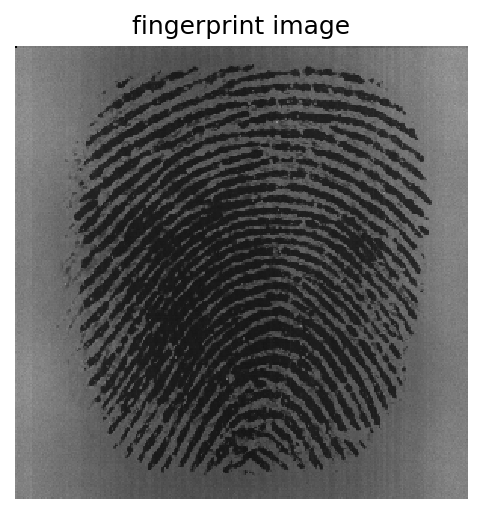

In [5]:
img = cv2.imread("101_1.tif", cv2.IMREAD_GRAYSCALE)
imshow(img, "fingerprint image")

## Part I: Fingerprint segmentation

### Class `FpSegmentator`

In [0]:
class FpSegmentator:
    def __init__(self, bs = 16, th = 160):
        self.blockSize = bs
        self.threshHold = th

    def segment(self, fpImg):
        segmentedImg = fpImg
        maskImg = fpImg
        #Perform edge detection using Canny technique
        blurImg = cv2.GaussianBlur(fpImg, (7,7), 0) 
        edgeImg = cv2.Canny(blurImg,  20, 70)

        rows, cols, *ch = maskImg.shape
        total = 0
        sd = 0
        size = self.blockSize ** 2

        #Compute statistical features of each block in input fingerprint image
        #And check if SD is less than the threshold value
        for row in range(0,rows, self.blockSize):
            for col in range(0,cols, self.blockSize):
                try:
                  #Calculate total pixels here
                    for r in range(row,row + self.blockSize):
                        for c in range(col,col + self.blockSize):
                            total += edgeImg[r,c]
                  #Calculate total sd of the edgeImg here
                    for r in range(row,row + self.blockSize):
                        for c in range(col,col + self.blockSize):
                            sd += (edgeImg[r,c] - (total // size))**2
                    total_sd = math.sqrt(sd // self.blockSize)
                    #Assign white color to the region with lower threshold 
                    if  total_sd < self.threshHold:
                        for r in range(row,row + self.blockSize):
                            for c in range(col,col + self.blockSize):
                                segmentedImg[r,c] = 255
                    #Reset the sd and total pix for each block
                    total = 0
                    sd = 0
                except IndexError as ie:
                    pass
        return segmentedImg

In [0]:
# test script
img = cv2.imread("1_1.tif", cv2.IMREAD_GRAYSCALE)
segmentator = FpSegmentator(16)
maskImg = segmentator.segment(img)
imshow(maskImg, "segment")

## Part II: Fingerprint enhancement

### Class `OfDetector`

In [0]:
class OfDetector:
  def __init__(self, bSize = 16):
    self.blockSize = bSize

  def computeOrientation(self, block):
      #Using Sobel technique to find gradient magnitude in X, Y axis of the block
      blockGx = cv2.Sobel(block, cv2.CV_32F, 1, 0)
      blockGy = cv2.Sobel(block, cv2.CV_32F, 0, 1)
      numerator = 0
      denominator = 0
      rows, cols = blockGx.shape
      #Estimate local ridge orientation based on specified formula
      for row in range(rows):
          for col in range(cols):
              numerator += 2 * blockGx[row, col] * blockGy[row, col]
              denominator += (blockGx[row, col]) ** 2 - (blockGy[row, col])**2
      theta = (np.arctan2(numerator, denominator)) / 2

      # Rotate the orientations so that they point along the ridges, and wrap
      # them into only half of the circle (all should be less than 180 degrees).
      theta = (theta + np.pi * 0.5) % np.pi
      return math.degrees(theta)

  def quantizeOrientation(self, orientation):
      #This function used to estimate the local ridge orientation
      orientations = [0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5]
      #In case that the orientation is less negative
      if orientation < 0 :
          orientation += 360
      #In case that the orientation exceeds 180 degree
      if orientation > 180:
          orientation /= 2
      max_angle = 999
      currentOrientation = 0
      for angle in orientations:
          #Check the difference between the input angle and orientation in orientation list
          angle_diff = abs(angle - orientation)
          #In case that the angle is less than max Angle
          if angle_diff < max_angle:
              max_angle = angle_diff
              currentOrientation = angle
      return currentOrientation

  def ridge_estimation(self, img, block_size):
      #Assign the orientation to the block in the part of input fingerprint
      rows, cols = img.shape
      orientations_matrix = np.zeros((rows //block_size + 1 , cols // block_size + 1), dtype = np.float32)
      block_rows = block_size
      block_cols = block_size
      for row in range(0, rows, block_size):
          end_row = row + block_size
          for col in range(0, cols, block_size):
              end_col = col + block_size
              block = img[row : end_row, col : end_col]
              orientations_matrix[row // block_size, col // block_size] = self.quantizeOrientation(self.computeOrientation(block))
      return orientations_matrix

  def drawOFimage(self,ofImg,angle,x,y):
    margin = 3
    #Convert the degree -> radian and apply sine function to calculate the destination point
    angle = np.deg2rad(angle)
    x2 =  (self.blockSize - margin ) * np.cos(angle)
    y2 =  (self.blockSize - margin ) * np.sin(angle)

    #Draw a black line with size of 1 px in a block with starting point(x,y) to destination point(x2,y2)  
    cv2.line(ofImg, (x,y), (int(x + x2) , int(y + y2)), (0, 0, 0) , 1)

  def detect(self, fpImg, mskImg):
      tmpImg = fpImg
      rows, cols = tmpImg.shape
      yblocks, xblocks = rows//self.blockSize, cols//self.blockSize
      orientations = self.ridge_estimation(tmpImg, self.blockSize)
      #Create the Matrix that stores the value of orientations
      ofMat = orientations
      #Construct ofImg to be used in Fingerprint Enhancement 
      ofImg = np.full(tmpImg.shape, -1.0)
      #Create empty white image used to plot lines showing orientation field
      #whiteImg = np.ones(tmpImg.shape, dtype=np.uint8) * 255
      for y in range(yblocks):
          for x in range(xblocks):
              #Assign orientation to each block inside of ofImg
              ofImg[y * self.blockSize : (y+1) * self.blockSize, x * self.blockSize : (x+1) * self.blockSize] = ofMat[y, x]
              #Plot local ridge line onto each block on whiteImg
              #self.drawOFimage(whiteImg, ofMat[y, x] ,x * self.blockSize, y * self.blockSize)
      
      #Overlay the plotted image onto original image
      #imshow(cv2.addWeighted(fpImg,0.25,whiteImg,0.75,1),"calculated orientation field")
      return ofMat, ofImg   

In [0]:
# test script


### Class `GaborFilter`

In [0]:
class GaborFilter:
  def __init__(self, size, sigma_val, orientation, frequency):
    #print("Constructing a Gabor filter with params: {}, {}, {}, {}".format(size,sigma_val,orientation,frequency))
    self.size = size
    self.sigma_val = sigma_val

    #convert the degree to radian
    self.theta = ( orientation * np.pi ) / 180 
    self.frequency = frequency
    # -> ksize = filter size
    # -> sigma = Standard deviation of function used in GaborFilter
    # -> theta = orientation of the GaborFilter
    # -> Lambda = Wavelength of Sine graph
    # -> Gamma = spatial aspect ratio
    # -> psi = Phase offset
    # -> ktype = type/range of values that each pixel in GaborFilter can hold 

    self.kernel = cv2.getGaborKernel((self.size, self.size), self.sigma_val, self.theta, self.frequency, 4, 0, cv2.CV_32F)
  
  def getGaborFilter(self):
    return self.kernel

  def drawFilter(self):
    #Used to visualise the Gabor filter
    filterImg = cv2.convertScaleAbs(self.kernel,alpha=100)
    return filterImg

  def filter(self, block):
    #Perform Convolution operation to the block
    filteredImage = cv2.filter2D(block, cv2.CV_8U, self.kernel)
    return filteredImage

In [0]:
# test script


### Class `GaborFilterbank`

In [0]:
class GaborFilterbank:
  def __init__(self, frequency, kernel_size, sigma):
    self.frequency = frequency
    self.kernel_size = kernel_size
    self.sigma = sigma
    self.gaborFilters = {}

    #Using dictionary to store the key of orientation associated with Gabor Filter with the key orientaion
    self.orientations = [0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5]
    for orientation in self.orientations:
      self.gaborFilters[orientation] = GaborFilter(self.kernel_size, self.sigma, orientation, self.frequency)

  def drawGaborFilterBank(self):
    #Visualise the generated Gabor filter with different angles
    for orientation in self.orientations:
      imshow(self.gaborFilters[orientation].drawFilter(), "Filter" + str(orientation))
      
  def getGaborFilters(self):
    return self.gaborFilters

  def isAtBeginEdge(self, pos, padding):
    #For row -> Left of img
    #For col -> Top of Img
    val = 0
    if(pos - padding > 0):
      val =  pos - padding
    else:
      val =  0
    return val

  def isAtEndEdge(self, pos,border, block, padding):
    #For row -> Right of img
    #For col -> Bottom of Img
    val = 0
    if(pos + padding + block < border):
      val = pos + padding + block
    else:
      val = border
    return val
  
  def filter(self, fpImg, ofImg, mskImg):
    img = fpImg
    fixed_block = self.kernel_size #16
    rows, cols = img.shape

    # Assign the angle from Orientation Field Image to Orientation matrix
    orientations = np.zeros((rows // fixed_block , cols // fixed_block), dtype = np.float32)
    for row in range(orientations.shape[0]):
        for col in range(orientations.shape[1]):
            orientations[row, col] = ofImg[row * fixed_block + 1, col * fixed_block + 1]
    
    block_rows = fixed_block
    block_cols = fixed_block
    padding = self.kernel_size // 2 + 1 #6

    for row in range(0, rows, fixed_block-1):
        r1 = self.isAtBeginEdge(row, padding)
        r2 = self.isAtEndEdge(row, rows, fixed_block, padding)
        
        for col in range(0, cols, fixed_block-1):
            c1 = self.isAtBeginEdge(col ,  padding)
            c2 = self.isAtEndEdge(col, cols, fixed_block, padding)

            block = img[r1 : r2, c1 : c2]
            orientation = orientations[row // fixed_block , col // fixed_block]

            orientation = (orientation - 90)
            if(orientation < 0):
              orientation += 180
            if (orientation > 180):
              orientation /= 2
            
            gabor = self.gaborFilters[orientation]
            img[row : row + fixed_block , col : col + fixed_block] = gabor.filter(block)[row - r1 : row - r1+ fixed_block , col - c1 : col - c1 + fixed_block]
            
            #imshow(gabor.drawFilter() , "Applied Filter") <- Debugging
    
    img = np.where(mskImg==0, img, 255)

    return img

In [0]:
# test script


### Class `FpEnhancer`

In [0]:
class FpEnhancer:
  def __init__(self,bSize = 16):
    self.blockSize = bSize
  # Create the mask to extract only ROI of the fingerprint image
  def createMask(self, segmentedImg, n = 16):
    rows, cols = segmentedImg.shape
    mask = np.zeros(segmentedImg.shape, dtype = np.uint8)
    white = np.ones((n, n), dtype = np.uint8) * 255
    toRemove = []

    for row in range(0, rows, n):
        for col in range(0, cols, n):
            block = segmentedImg[row : row + n, col : col +n]
            if np.array_equal(white, block):
              mask[row : row + n, col : col + n] = 255
            else:
              mask[row : row + n, col : col + n] = 0
      
    for row in range(0, rows, n):
        for col in range(0, cols, n):
            if (row - n < 0 or col - n < 0 or row + n + 1 > rows or col + n + 1 > rows):
                toRemove.append( (row, col) )
            elif (mask[row + 1, col + 1]==0) and (mask[row + n + 1, col + 1]==255 
                                                  or mask[row - n + 1, col + 1]==255 
                                                  or mask[row + 1, col - n + 1]==255 
                                                  or mask[row + 1, col + n + 1]==255):
                toRemove.append((row , col))

    for element in toRemove:
        row, col = element[0], element[1]
        mask[row : row + n, col : col + n] = 255 #Assign white color to the removed region
        
    return mask

  def enhance(self, fpImg, mskImg):
    mskImg2 = self.createMask(fpImg,self.blockSize)
    ofDetector = OfDetector(self.blockSize)
    ofMat, ofImg = ofDetector.detect(fpImg, mskImg)
    gaborFilterBank = GaborFilterbank(10.0, 10, 3.0)
    enhImg = gaborFilterBank.filter(fpImg, ofImg, mskImg2)
    return enhImg

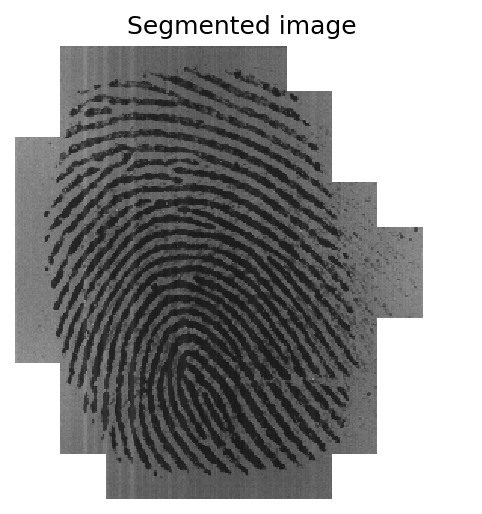

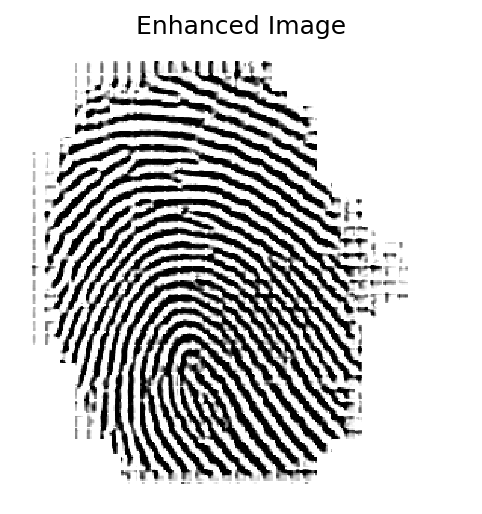

In [126]:
#test script
img = cv2.imread("106_1.tif", cv2.IMREAD_GRAYSCALE)
segmentator = FpSegmentator(30,150)
img = segmentator.segment(img)
imshow(img, "Segmented image")
enhancer = FpEnhancer(10)
enhImg = enhancer.enhance(img, np.ones(img.shape) * 255)
imshow( enhImg,"Enhanced Image")

## Part III: Minutia extraction

### Class `Binarizer`

In [0]:
class Binarizer:
  def __init__(self):
    pass
  def binarize(self,fpImg):
    #Blurring image to optimize the performance of Thresholding
    #bluredImg = cv2.GaussianBlur(fpImg,(3,3),cv2.BORDER_DEFAULT)
    retVal, binarized_image = cv2.threshold(fpImg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return binarized_image

In [0]:
# test script


### Class `Skeletonizer`

In [0]:
class Skeletonizer:
  # Thinning is performed by iterating through 3 x 3 region and observe its neighbours
  # --------------------------
  #    p1  |   p2   |   p3   |   
  #    p8  |   p2   |   p4   |
  #    p7  |   p6   |   p5   |
  # --------------------------
  def __init__(self):
    pass
  def count_black_neighbour(self, img, row_pos, col_pos):
    #Iterating through the neighbour of p from p2 -> p3 -> p4 -> p5 -> p6 -> p7 -> p8
    count = 0
    for neighbour_row in range(-1, 2):
        for neighbour_col in range(-1, 2):
            if neighbour_row == 0 and neighbour_col == 0:
                continue
            elif img[row_pos + neighbour_row][col_pos + neighbour_col] == 0:
                count += 1
    return count

  def count_transition(self, img, row_pos, col_pos):
    #Iterating through the neighbour of p from p2 -> p3 -> p4 -> p5 -> p6 -> p7 -> p8
    transitions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0)]
    count = 0
    for transition in range(1, len(transitions)):
      row = row_pos + transitions[transition][0]
      col = col_pos + transitions[transition][1]
      prev_row = row_pos + transitions[transition - 1][0]
      prev_col = col_pos + transitions[transition - 1][1]
      if img[prev_row, prev_col] == 255 and img[row, col] == 0:
        count += 1
    return count

  def areConPixelsWhite(self, img):
      #Case 2 4 6
      if img[0, 1] == 255 or img[1, 2] == 255 or img[2, 1] == 255:
        return True
      #Case 4 6 8
      elif img[1, 2] == 255 or img[2, 1] == 255 or img[1, 0] == 255:
        return True
      #Case 2 4 8
      elif img[0, 1] == 255 or img[1, 2] == 255 or img[1, 0] == 255:
          return True
      #Case 2 6 8
      elif img[0, 1] == 255 or img[2, 1] == 255 or img[1, 0] == 255:
          return True
      return False
  
  def skeletonize(self, binImg):
    rows, cols = binImg.shape
    for row in range(1, rows - 1):
      for col in range(1, cols - 1):
          if binImg[row][col] == 0:
              if(self.count_black_neighbour(binImg, row, col) >= 2) and (self.count_black_neighbour(binImg, row, col) <= 6):
                  if self.count_transition(binImg, row, col) == 1:
                    if self.areConPixelsWhite(binImg[row - 1 : row + 2 , col - 1 : col + 2 ]):
                      binImg[row][col] = 255
    return binImg

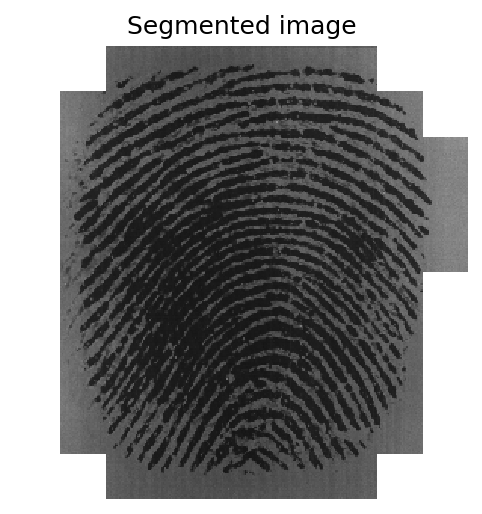

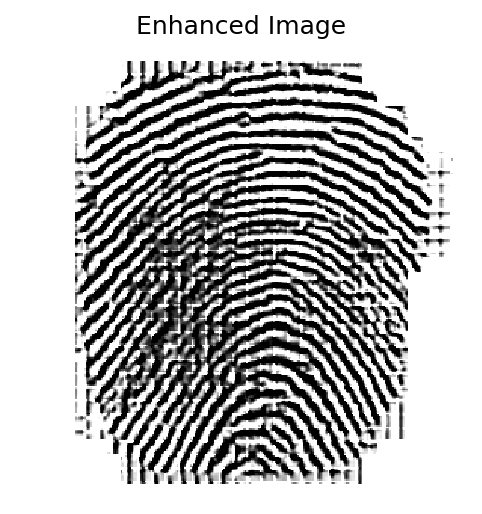

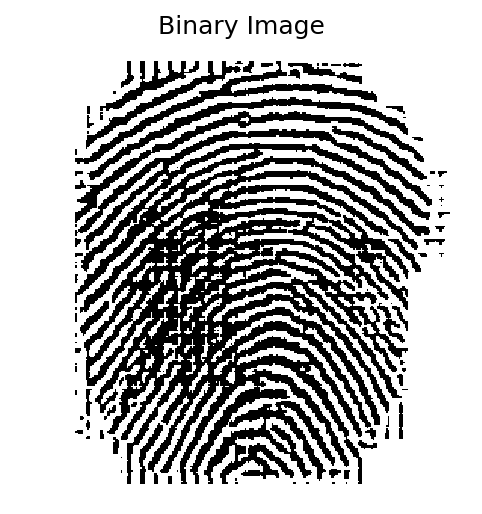

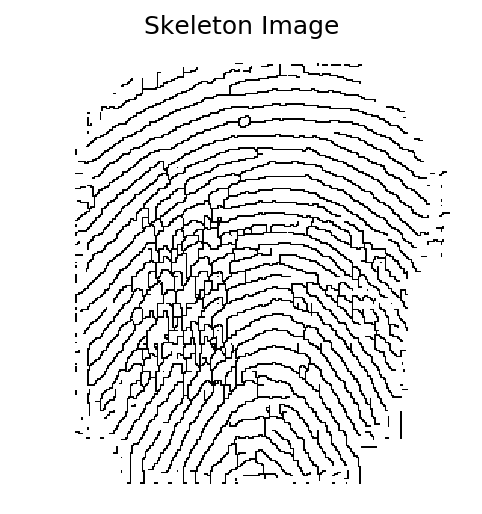

In [127]:
#test script
img = cv2.imread("101_1.tif", cv2.IMREAD_GRAYSCALE)
segmentator = FpSegmentator(30,150)
img = segmentator.segment(img)
imshow(img, "Segmented image")
enhancer = FpEnhancer(10)
enhImg = enhancer.enhance(img, np.ones(img.shape) * 255)
imshow( enhImg,"Enhanced Image")
binarizer = Binarizer()
binImg = binarizer.binarize(enhImg)
imshow( binImg,"Binary Image")
sk = Skeletonizer()
skImg = sk.skeletonize(binImg)
imshow( skImg,"Skeleton Image")

### Class `MnExtractor`

In [0]:
# minutiae types
M_TYPE_UNKNOWN      = 0
M_TYPE_ENDPOINT     = 1
M_TYPE_BIFURCATION  = 2

In [0]:
class MnExtractor:
    def __init__(self):
        self.binarizer = Binarizer()
        self.skeletonizer = Skeletonizer()

    #Calculate the crossing number
    def calculate_cn(self, img, row_pos, col_pos):
      #Iterating through the neighbour of p from p2 -> p3 -> p4 -> p5 -> p6 -> p7 -> p8
        transitions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0)]
        total = 0
        for transition in range(len(transitions) - 1):
            row = row_pos + transitions[transition][0]
            col = col_pos + transitions[transition][1]
            next_row = row_pos + transitions[transition + 1][0]
            next_col = col_pos + transitions[transition + 1][1]
            total += abs(img[row, col] / 255 - img[next_row, next_col] / 255) #Normalize to 0 - 1
        return total / 2

    #Check if the point is located at the edge of the region or not
    #Shifing from right to left
    def isLeftBoundary(self, img, row_pos, col_pos):
        rows, cols = img.shape
        isBound = True
        for k in range(col_pos - 1, -1, -1):
            #If detected black part within the block
            if img[row_pos, k] == 0:
                isBound = False
                break
        return isBound
    #Shifing from left to right
    def isRightBoundary(self, img, row_pos, col_pos):
        rows, cols = img.shape
        isBound = True
        for k in range(col_pos + 1, cols):
             #If detected black part within the block
            if img[row_pos, k] == 0:
                isBound = False
                break
        return isBound

    #This is used to handle bifurcation minutia case since it's joint between 3 lines and not the endpoint.
    def isBoundary(self, img, row_pos, col_pos):
        if self.isLeftBoundary(img, row_pos, col_pos) or self.isRightBoundary(img, row_pos, col_pos):
            return True
        return False

    #Euclidian distance between 2 points
    def distance(self, x1, y1, x2, y2):
        return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def extract(self, enhancedImg):
        rows, cols = enhancedImg.shape
        binImg = self.binarizer.binarize(enhancedImg)
        skeletonImg = self.skeletonizer.skeletonize(binImg)
        #Set of minutias
        mnSet = []
        count = 0
        for row in range(1, rows - 1):
            for col in range(1, cols - 1):
                if(skeletonImg[row, col] == 0):
                    cn = self.calculate_cn(skeletonImg, row, col)
                    if cn == 1:
                        #In case that crossing number is 1 -> Endpoint Minutia
                        mnSet.append([row, col, M_TYPE_ENDPOINT])
                    elif cn == 3 and not self.isBoundary(enhancedImg, row, col):
                        #In case that crossing number is 3 -> Bifurcation Minutia
                        mnSet.append([row, col, M_TYPE_BIFURCATION])
        #Sort all of detected minutiae by distance between coordinate of minutia point from the center of enhanced image
        mnSet.sort(key=lambda coord: self.distance(rows // 2, cols // 2, coord[0], coord[1]))
        return mnSet


In [0]:
# test script


## Part IV: Matching

### Class `MnMatcher`

In [0]:
class MnMatcher:
    def __init__(self):
      pass
    #Basic operations required for Matcher
    #Swap the list in case that the input point list has longer length compared to given point list
    def listSwap(self, list1, list2):
        temp = list1
        list1 = list2
        list2 = temp
        return list1, list2

    # Translating all the points in the list to specified point
    def translateAllPoints(self, index1, index2, list1, list2):
        delta_x = list2[index2][0] - list1[index1][0] 
        delta_y = list2[index2][1] - list1[index1][1] 
        translated_point_list = []
        for i in range(len(list1)):
            new_x, new_y = self.translation(list1[i][0], list1[i][1], delta_x, delta_y)
            translated_point_list.append([new_x, new_y])
            
        return translated_point_list
    # Translate the location of a point
    def translation(self, x1,y1,delta_x, delta_y):
        x1 = x1 + delta_x
        y1 = y1 + delta_y
        return x1, y1

    def allAboutRotations(self, index1, index2, list1, list2, index_of_rotation_pts):
        # 1. translate every input points to 0,0
        all_input_pts_at_originate = self.translatePointsToOrigin(index_of_rotation_pts,list1)

        # 1.2 translate every given points to 0,0
        all_given_pts_at_originate = self.translatePointsToOrigin(index_of_rotation_pts,list2)
        
        # 2. find angle
        rotation_angle = self.findAngle(all_input_pts_at_originate[index1][0],
                                   all_input_pts_at_originate[index1][1],
                                   all_given_pts_at_originate[index2][0],
                                   all_given_pts_at_originate[index2][1])
        if(rotation_angle == 1):
            return 0
        # 3. rotate
        all_original_rotated_pts = self.rotateAllPoints(rotation_angle, all_input_pts_at_originate)

        maxs = 0
        # 4. verify rotation
        accuracy, error_rate = self.pointsVerification(all_original_rotated_pts,
                                                 all_given_pts_at_originate,
                                                 7)
        return accuracy

    # Calculate the angle between 2 points
    def findAngle(self, x1,y1,x2,y2):
        
        uv = (x1 * x2) + (y1 * y2)
        __u__ = (x1**2 + y1**2)**0.5
        __v__ = (x2**2 + y2**2)**0.5

        if(( __u__ * __v__) == 0):
            return 1
          
        cosSeta = uv / ( __u__ * __v__)
        if(cosSeta > 1 or cosSeta < -1):
            cosSeta = 1
        angle = math.acos(cosSeta)
        
        angle = (math.pi * 2) - (angle % (math.pi * 2))
        return angle

    def translatePointsToOrigin(self, index_of_rotation_pts , list1):
        pts_at_origin = []
        for i in range(len(list1)):
            new_x, new_y = self.translation(list1[i][0],list1[i][1],list1[index_of_rotation_pts][0] * -1, list1[index_of_rotation_pts][1] * -1)
            pts_at_origin.append([new_x, new_y])
        
        return pts_at_origin
        
    # Rotate all points with respect to the specified angle
    def rotateAllPoints(self, angle, list1):
        rotated_pts = []
        cos_value = (math.cos(angle))
        sin_value = (math.sin(angle))
        for i in range(len(list1)):
            new_x = round((cos_value * list1[i][0]) + (sin_value * -1 * list1[i][1]))
            new_y = round((sin_value * list1[i][0]) + (cos_value * list1[i][1]))
            rotated_pts.append([new_x, new_y])

        return rotated_pts

    # Verify the points within the fingerprint
    def pointsVerification(self, input_pts, given_pts,radius):
        total_given_pts = len(given_pts)
        total_input_pts = len(input_pts)
        match = 0
        not_match = 0

        # with radius
        never_meet = 1
        for i in range(len(input_pts)):
            for j in range(len(given_pts)):
                if((input_pts[i][0] + radius >= given_pts[j][0] and given_pts[j][0] >= input_pts[i][0] - radius)
                   and
                   (input_pts[i][1] + radius >= given_pts[j][1] and given_pts[j][1] >= input_pts[i][1] - radius)):
                    match += 1
                    never_meet = 0
                    break
                
            if(never_meet == 1):
                not_match += 1
            else:
                never_meet = 1
            
        accuracy = match/total_input_pts
        error_rate = not_match/total_input_pts
        return accuracy,error_rate
  
    def samplingPoint(self, list1, size):
        step_size = int(len(list1)/size)
        sampling_set = []
        for i in range(0,10):
            sampling_set.append(list1[i])

        for i in range(100,110):
            sampling_set.append(list1[i])
        print("SAMPLING", sampling_set)
        return sampling_set

    def createSample4Part(self, list1, list2, sample_size):
        from_each_population = round(sample_size / 4)
        sample_list = []
        for i in range(from_each_population):
            sample_list.append(list1[i])
            
        for i in range(len(list1)- from_each_population, len(list1)):
            sample_list.append(list1[i])

        for i in range(from_each_population):
            sample_list.append(list2[i])
            
        for i in range(len(list2)- from_each_population, len(list2)):
            sample_list.append(list2[i])

        print("sample: ", sample_list)
        return sample_list

    def createSample2Part(self, list1, list2, sample_size):
        from_each_population = round(sample_size / 2)
        sample_list = []
        for i in range(from_each_population):
            sample_list.append(list1[i])
        for i in range(from_each_population):
            sample_list.append(list2[i])

        print("sample: ", sample_list)
        return sample_list

    def normalSampling(self, list1, size):
        sample_list = []
        for i in range(size):
            sample_list.append(list1[i])
        return sample_list

    def sampling(self, list1, size):
      count = 0
      sample_list = []

      for i in range(len(list1)):
          if(count == size):
              break
          if(list1[i][2] == 2):
              continue
          sample_list.append(list1[i])
          count += 1
      
      return sample_list
            

    def match(self, mnSet1, mnSet2):
        input_point_list = self.sampling(mnSet1,20)
        given_point_list = self.sampling(mnSet2,20)
        
        if(len(input_point_list) > len(given_point_list)):
            print("swap list")
            input_point_list, given_point_list = self.listSwap(input_point_list,given_point_list)
        answer = 0
        maxs = 0
        for i in range(len(input_point_list)):
            for j in range(len(given_point_list)):
                translated_points = self.translateAllPoints(i,j,input_point_list,given_point_list)     
                for k in range(len(translated_points)):
                    for l in range(len(given_point_list)):   
                        similarity = self.allAboutRotations(k,l,translated_points,given_point_list, i)
                        if(similarity > maxs):
                            maxs = similarity
                        if(similarity >= 0.80):
                            maxs = similarity
                            answer = 1
                        if(answer == 1):
                            break
                    if(answer == 1):
                        break
                if(answer == 1):
                    break
            if(answer == 1):
                break    
        if(answer == 1):
            print("************************")
            print("    Fingerprint MATCH   ")
            print("************************")
        else:
            print("**************************")
            print("  Fingerprint NOT MATCH   ")
            print("**************************")
        return maxs


### Class `FpMatcher`

In [0]:
class FpMatcher:
    def __init__(self):
        self.segmentator = FpSegmentator(30,150)
        self.enhancer = FpEnhancer(10)
        self.extractor = MnExtractor()
        self.matcher = MnMatcher()

    def match(self, fpImg1, fpImg2):
        segmentedFpImg1 = self.segmentator.segment(fpImg1)
        enhancedFpImg1 = self.enhancer.enhance(segmentedFpImg1, np.ones(segmentedFpImg1.shape)*255)
        mnSet1 = self.extractor.extract(enhancedFpImg1)

        segmentedFpImg2 = self.segmentator.segment(fpImg2)
        enhancedFpImg2 = self.enhancer.enhance(segmentedFpImg2, np.ones(segmentedFpImg2.shape)*255)
        mnSet2 = self.extractor.extract(enhancedFpImg2)

        return self.matcher.match(mnSet1, mnSet2) * 100
 

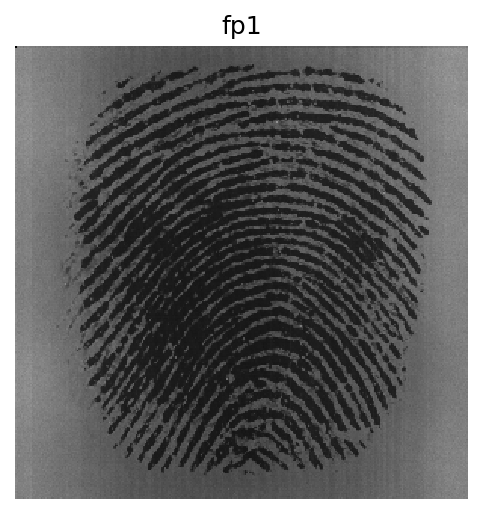

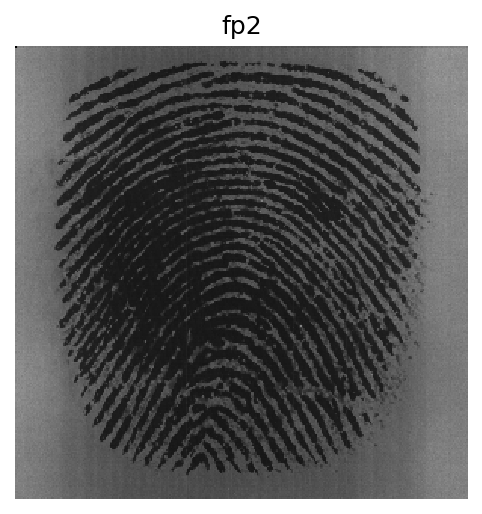

************************
    Fingerprint MATCH   
************************
Similary =  80.0


In [132]:
# test script

# read fingerprint image 1
fpImg1 = cv2.imread("101_1.tif", cv2.IMREAD_GRAYSCALE)
imshow(fpImg1, "fp1");

# read fingerprint image 2
fpImg2 = cv2.imread("101_2.tif", cv2.IMREAD_GRAYSCALE)
imshow(fpImg2, "fp2");

# match two fingerprint images
fpMatcher = FpMatcher()
similarity = fpMatcher.match(fpImg1, fpImg2)
print("Similary = ", similarity)

## Evaluation

In [35]:
%cd /content/drive/My Drive/FP (test set)/
!ls

/content/drive/My Drive/FP (test set)
101_1.tif  103_1.tif  104_1.tif  106_1.tif  107_1.tif  DB_Info.txt
101_2.tif  103_2.tif  104_2.tif  106_3.tif  107_3.tif
101_4.tif  103_4.tif  104_4.tif  106_4.tif  107_4.tif


In [0]:
import time

#-----------------------------
def genFpImgName(fpNo, imgNo, ext):
    return fpNo + "_" + imgNo + ext
        
#-----------------------------
class FpMatchingEvaluator:
    def __init__(self):
        self.outFileName = "matching_result.txt"
        self.outFile = open(self.outFileName, "w")
        self.outFile.close()
        self.similaritySameFinger = []
        self.similarityDiffFinger = []
        self.falseAccept = [0] * 101
        self.falseReject = [0] * 101
        
    def evaluate(self, dbFileName, fpMatcher):
        print("------------------------------------------------")
        print("Start evaluation")
        print("------------------------------------------------")
        #reset attributes
        self.similaritySameFinger = []
        self.similarityDiffFinger = []
        #open file stream
        inFile = open(dbFileName, "r")
        #get file extension
        ext = inFile.readline().rstrip()
        #get path
        path = inFile.readline().rstrip()
        #get all image names
        line_list = inFile.readlines()
        fpFiles = [x.split() for x in line_list]

        #for all pairs of fingerprint images
        total_time = 0;
        for i in range(len(fpFiles)):
            for j in range(i + 1, len(fpFiles)):
                #read images
                name1 = genFpImgName(fpFiles[i][0], fpFiles[i][1], ext)
                #fpImg1 = cv2.imread(path + name1, cv2.IMREAD_GRAYSCALE)
                fpImg1 = cv2.imread(name1, cv2.IMREAD_GRAYSCALE)
                name2 = genFpImgName(fpFiles[j][0], fpFiles[j][1], ext)
                #fpImg2 = cv2.imread(path + name2, cv2.IMREAD_GRAYSCALE)
                fpImg2 = cv2.imread(name2, cv2.IMREAD_GRAYSCALE)

                #imshow(fpImg1, "Test image 1")
                #imshow(fpImg2, "Test image 2")

                #matching
                start_time = time.time()
                s = fpMatcher.match(fpImg1, fpImg2)
                elapse_time = time.time() - start_time
                total_time += elapse_time
                print(name1, "vs", name2, ":", s)
                self.outFile = open(self.outFileName, "a")
                self.outFile.write(name1 + " vs " + name2 + " : " + str(s) + "\n")
                self.outFile.close()
                print("Time : ", elapse_time, "s. Total time : ", total_time, "s.")
                #save similarity
                if fpFiles[i][0] == fpFiles[j][0]:
                    self.similaritySameFinger.append(s)
                else:
                    self.similarityDiffFinger.append(s)

        #calculate the performace
        self.calculateResults()
                    
    def calculateResults(self):
        print("------------------------------------------------")
        print("Calculate FA & FR at each threshold")
        print("------------------------------------------------")
        self.outFile = open(self.outFileName, "a")
        for th in range(101):
            numFalseAccept = 0
            numFalseReject = 0

            #check genuine attempt vector
            for s in self.similaritySameFinger:
                if s < th:
                    numFalseReject += 1
                    
            #check imposter attempt vector
            for s in self.similarityDiffFinger:
                if s >= th:
                    numFalseAccept += 1

            #compute false acceptance and false rejection rates
            self.falseAccept[th] = numFalseAccept / len(self.similarityDiffFinger) * 100
            self.falseReject[th] = numFalseReject / len(self.similaritySameFinger) * 100

            #display
            print("threshold = ", th, ":", \
                  "false accept = ", self.falseAccept[th], \
                  "false reject = ", self.falseReject[th])
            self.outFile.write("threshold = " + str(th) + ":" + \
                  "false accept = " + str(self.falseAccept[th]) + \
                  "false reject = " + str(self.falseReject[th]) + "\n")

        eer = self.calculateEER()
        print("EER = ", eer)
        self.outFile.write("EER = " + str(eer) + "\n")
        self.outFile.close()

        # plot graphs
        self.plotROC()
        self.plotFAR_FRR()

    def plotROC(self):
        fig = plt.figure()
        plt.plot(self.falseReject, self.falseAccept, color='tab:blue', label='FAR')
        plt.grid()
        plt.xlabel("FRR (%)")
        plt.ylabel("FAR (%)")
        plt.title("ROC")
        plt.show()

    def plotFAR_FRR(self):
        th = np.arange(101)
        fig = plt.figure()
        plt.plot(th, self.falseAccept, color='tab:blue', label='FAR')
        plt.plot(th, self.falseReject, color='tab:orange', label='FRR')
        plt.grid()
        plt.xlabel("Threshold (%)")
        plt.ylabel("FAR & FRR (%)")
        plt.legend()
        plt.show()

    def calculateEER(self): 
        print("------------------------------------------------")
        print("Calculate EER")    
        print("------------------------------------------------")  
        #check if there is a case where FAR equals FRR
        for th in range(101):
            if self.falseReject[th] == self.falseAccept[th]:
                return self.falseReject[th]

        t1 = t2 = 0
        #find EER_low     
        for th in range(101):
            if self.falseReject[th] > self.falseAccept[th]:
                t1 = th
                break

        #find EER_high
        for th in reversed(range(101)):
            if self.falseReject[th] < self.falseAccept[th]:
                t2 = th
                break

        #cal EER
        if (self.falseReject[t1] + self.falseAccept[t1]) < \
           (self.falseReject[t2] + self.falseAccept[t2]):
            eer_low, eer_high = self.falseReject[t1], self.falseAccept[t1]
        else:
            eer_low, eer_high = self.falseAccept[t2], self.falseReject[t2]
        
        return (eer_low + eer_high) / 2

------------------------------------------------
Start evaluation
------------------------------------------------
************************
    Fingerprint MATCH   
************************
101_1.tif vs 101_2.tif : 80.0
Time :  8.529814958572388 s. Total time :  8.529814958572388 s.
************************
    Fingerprint MATCH   
************************
101_1.tif vs 101_4.tif : 80.0
Time :  7.53105902671814 s. Total time :  16.060873985290527 s.
************************
    Fingerprint MATCH   
************************
101_1.tif vs 103_1.tif : 80.0
Time :  6.482274055480957 s. Total time :  22.543148040771484 s.
************************
    Fingerprint MATCH   
************************
101_1.tif vs 103_2.tif : 80.0
Time :  6.92508339881897 s. Total time :  29.468231439590454 s.
**************************
  Fingerprint NOT MATCH   
**************************
101_1.tif vs 103_4.tif : 70.0
Time :  19.952667236328125 s. Total time :  49.42089867591858 s.
************************
    Fin

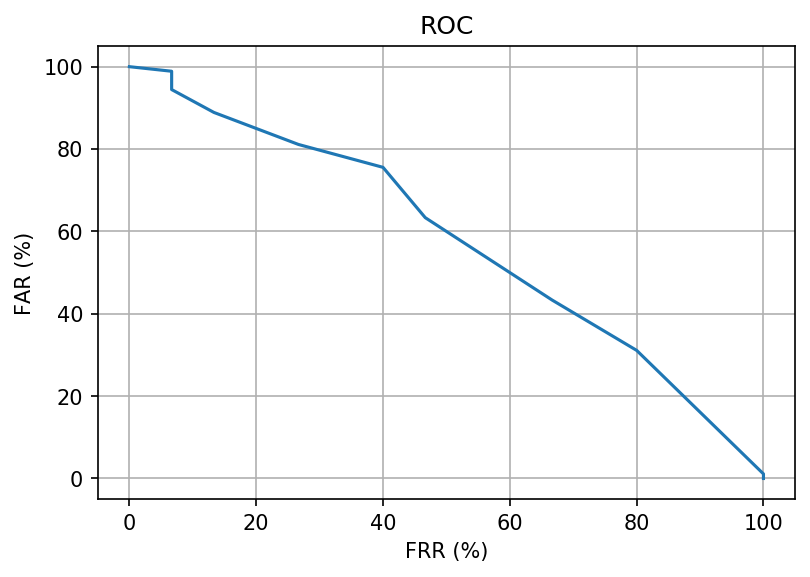

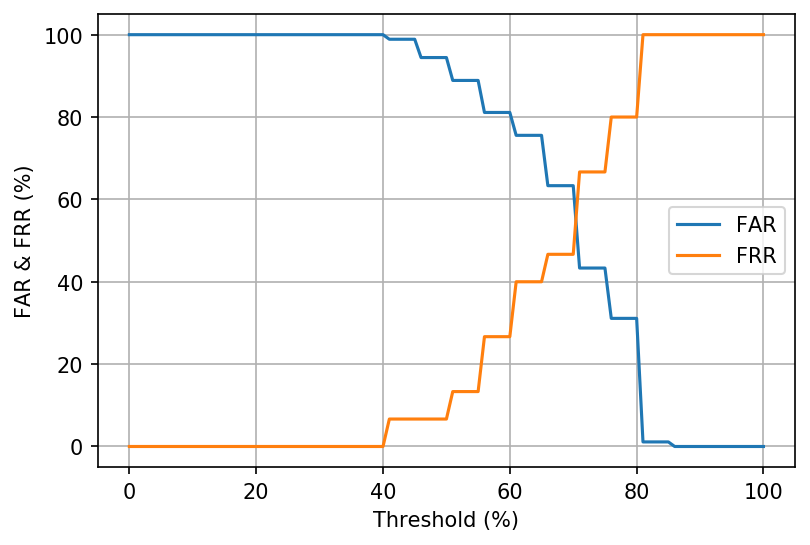

In [131]:
fpMatcher = FpMatcher()
fpEvl = FpMatchingEvaluator()
fpEvl.evaluate("DB_Info.txt", fpMatcher)